# Embedded ML Lab - Challenge (training yolo example)

This is an example of training with the VOC data set and tinyyolov2. Since training tinyyolo from scratch takes a very long time we start with pretrained weights.

In [ ]:
import torch

# A subset of VOCDataLoader just for one class (person) (0)
from utils.dataloader import VOCDataLoaderPerson

loader = VOCDataLoaderPerson(train=True, batch_size=1, shuffle=True)
loader_test = VOCDataLoaderPerson(train=False, batch_size=1)

from tinyyolov2 import TinyYoloV2
from utils.loss import YoloLoss
import tqdm
  

In [2]:
# We define a tinyyolo network with only two possible classes
net = TinyYoloV2(num_classes=1)
sd = torch.load("voc_pretrained.pt")

#We load all parameters from the pretrained dict except for the last layer
net.load_state_dict({k: v for k, v in sd.items() if not '9' in k}, strict=False)
net.eval()

# Definition of the loss
criterion = YoloLoss(anchors=net.anchors)

#We only train the last layer (conv9)
for key, param in net.named_parameters():
    if any(x in key for x in ['1', '2', '3', '4', '5', '6', '7']):
        param.requires_grad = False

optimizer = torch.optim.Adam(filter(lambda x: x.requires_grad, net.parameters()), lr=0.001)
  

100%|██████████| 350/350 [20:41<00:00,  3.55s/it]


average precision [0.09217192563469462]


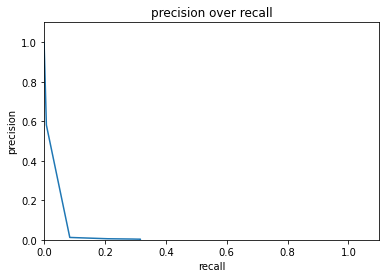

100%|██████████| 350/350 [09:11<00:00,  1.58s/it]


average precision [0.09217192563469462, 0.29742455487184144]


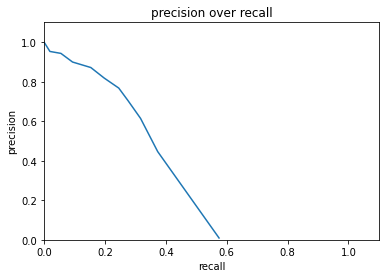

100%|██████████| 350/350 [09:00<00:00,  1.55s/it]


average precision [0.09217192563469462, 0.29742455487184144, 0.09113341595643237]


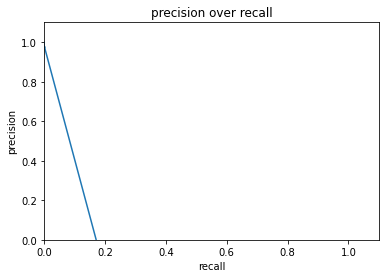

100%|██████████| 350/350 [09:01<00:00,  1.55s/it]


average precision [0.09217192563469462, 0.29742455487184144, 0.09113341595643237, 0.09242684158735472]


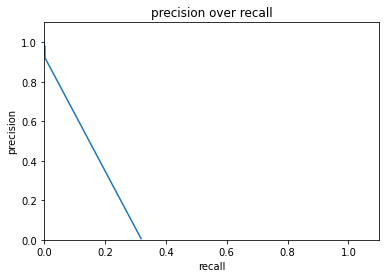

100%|██████████| 350/350 [09:03<00:00,  1.55s/it]


average precision [0.09217192563469462, 0.29742455487184144, 0.09113341595643237, 0.09242684158735472, 0.09219939996647471]


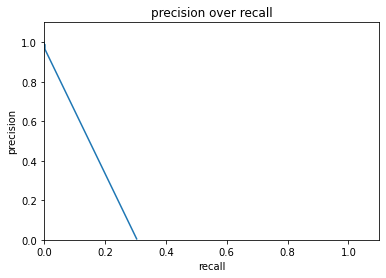

100%|██████████| 350/350 [09:05<00:00,  1.56s/it]


average precision [0.09217192563469462, 0.29742455487184144, 0.09113341595643237, 0.09242684158735472, 0.09219939996647471, 0.09180900828941076]


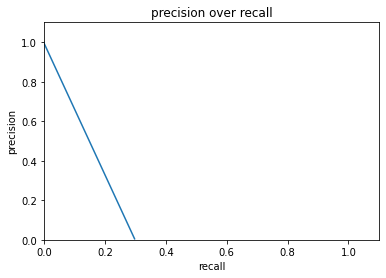

100%|██████████| 350/350 [08:58<00:00,  1.54s/it]


average precision [0.09217192563469462, 0.29742455487184144, 0.09113341595643237, 0.09242684158735472, 0.09219939996647471, 0.09180900828941076, 0.09257398675548387]


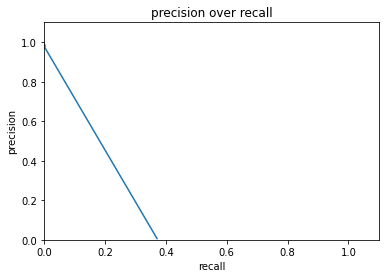

100%|██████████| 350/350 [09:19<00:00,  1.60s/it]


average precision [0.09217192563469462, 0.29742455487184144, 0.09113341595643237, 0.09242684158735472, 0.09219939996647471, 0.09180900828941076, 0.09257398675548387, 0.09407695410302792]


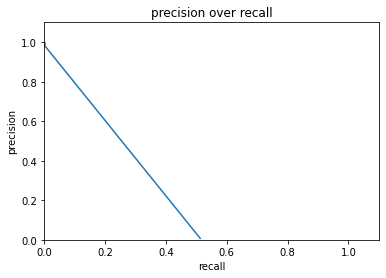

100%|██████████| 350/350 [09:33<00:00,  1.64s/it]


average precision [0.09217192563469462, 0.29742455487184144, 0.09113341595643237, 0.09242684158735472, 0.09219939996647471, 0.09180900828941076, 0.09257398675548387, 0.09407695410302792, 0.38595154843779583]


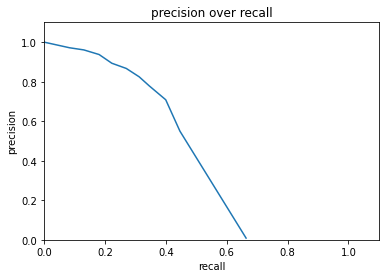

100%|██████████| 350/350 [09:34<00:00,  1.64s/it]


average precision [0.09217192563469462, 0.29742455487184144, 0.09113341595643237, 0.09242684158735472, 0.09219939996647471, 0.09180900828941076, 0.09257398675548387, 0.09407695410302792, 0.38595154843779583, 0.5521641532932141]


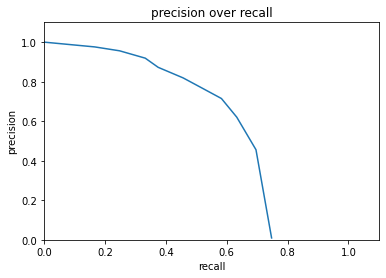

100%|██████████| 350/350 [09:39<00:00,  1.65s/it]


average precision [0.09217192563469462, 0.29742455487184144, 0.09113341595643237, 0.09242684158735472, 0.09219939996647471, 0.09180900828941076, 0.09257398675548387, 0.09407695410302792, 0.38595154843779583, 0.5521641532932141, 0.4419476098129145]


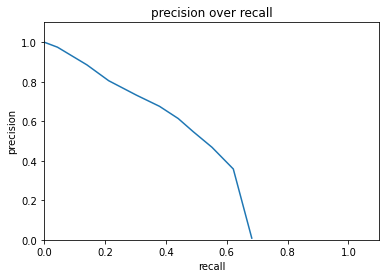

100%|██████████| 350/350 [09:40<00:00,  1.66s/it]


average precision [0.09217192563469462, 0.29742455487184144, 0.09113341595643237, 0.09242684158735472, 0.09219939996647471, 0.09180900828941076, 0.09257398675548387, 0.09407695410302792, 0.38595154843779583, 0.5521641532932141, 0.4419476098129145, 0.5710842931651878]


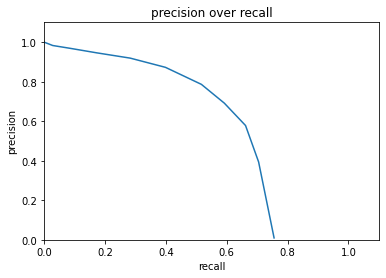

100%|██████████| 350/350 [09:25<00:00,  1.62s/it]


average precision [0.09217192563469462, 0.29742455487184144, 0.09113341595643237, 0.09242684158735472, 0.09219939996647471, 0.09180900828941076, 0.09257398675548387, 0.09407695410302792, 0.38595154843779583, 0.5521641532932141, 0.4419476098129145, 0.5710842931651878, 0.5070071931947148]


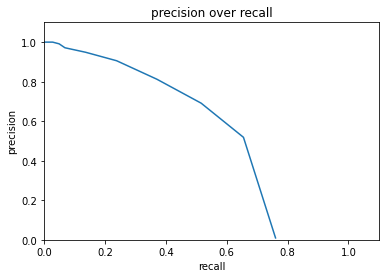

 76%|███████▌  | 1630/2142 [45:30<14:07,  1.65s/it] 

In [ ]:
from utils.ap import precision_recall_levels, ap, display_roc
from utils.yolo import nms, filter_boxes

NUM_TEST_SAMPLES = 350
NUM_EPOCHS = 15
test_AP = []

for epoch in range(NUM_EPOCHS):
    if epoch != 0:
        for idx, (input, target) in tqdm.tqdm(enumerate(loader), total=len(loader)):

            optimizer.zero_grad()

            #Yolo head is implemented in the loss for training, therefore yolo=False
            output = net(input, yolo=False)
            loss, _ = criterion(output, target)
            loss.backward()
            optimizer.step()

            
    test_precision = []
    test_recall = []
    with torch.no_grad():
        for idx, (input, target) in tqdm.tqdm(enumerate(loader_test), total=NUM_TEST_SAMPLES):
            output = net(input, yolo=True)
            
            #The right threshold values can be adjusted for the target application
            output = filter_boxes(output, 0.0)
            output = nms(output, 0.5)
            
            precision, recall = precision_recall_levels(target[0], output[0])
            test_precision.append(precision)
            test_recall.append(recall)
            if idx == NUM_TEST_SAMPLES:
                break
                
    #Calculation of average precision with collected samples
    test_AP.append(ap(test_precision, test_recall))
    print('average precision', test_AP)

    #plot ROC
    display_roc(test_precision, test_recall)
    
    state_dict = net.state_dict()
    torch.save(state_dict, 'zhz_sr_1.pt')
            
            